<a href="https://colab.research.google.com/github/simseoyoung/Deep-Learning/blob/main/CH.7/Feedforward_GAN_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FeedForward GAN

- Fashion MNIST 사용

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
import random
import torchvision

import pandas as pd

from torchvision.utils import save_image

from tensorflow.keras import datasets

import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cpu


In [4]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

[1] Data processing

In [5]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

print("x_train 의 length = {}".format(len(x_train)))
print("x_test 의 length = {}".format(len(x_test)))

4431872/4422102 [==============================] - 0s 0us/step
x_train 의 length = 60000
x_test 의 length = 10000


In [6]:
x_train=np.asarray(x_train)
y_train=np.asarray(y_train)
x_test=np.asarray(x_test)
y_test=np.asarray(y_test)

# Rescale the image data to 0 ~ 1. 
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

print("x_train 의 shape={}, x_test 의 shape={}".format(x_train.shape, x_test.shape))

x_train 의 shape=(60000, 28, 28), x_test 의 shape=(10000, 28, 28)


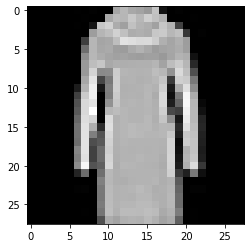

In [7]:
# load dataset using dataloader
batch_size = 100

# batch size 만큼 나누어서 data를 로드
train_loader = torch.utils.data.DataLoader(x_train ,batch_size=batch_size, shuffle=True, num_workers=0,drop_last=False)
test_loader = torch.utils.data.DataLoader(x_test ,batch_size=len(x_test), shuffle=False, num_workers=0,drop_last=False)

# show image
for batch_idx, image in enumerate(train_loader):
    plt.imshow(image[0].reshape(28,28), cmap="gray")
    break

[2] Model

In [8]:
# random distribution 의 dim(z_dim) 설정
z_size = 500

# Discriminator 와 같은역할
# 저차원 데이터를 고차원으로 만들어 준다

# input으로 noise를 넣어줘야함
class Generator(nn.Module):
    def __init__(self, z_size):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(z_size, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 784)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2) # negative slope = 0.2
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        
        return torch.tanh(self.fc4(x))

In [9]:
# 입력받은 이미지가 진짜인지 가짜인지 판별

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        
        # 마지막으로 0~1 사이의 값을 내보내도록 sigmoid 를 거쳐준다
        # 0 혹은 1 로 나타내지 않고 0~1 사이의 연속된 수로 나타내는 이유는 Discriminator 가 얼마나 확신을 가지고 있는지 알기 위해서
        # if output 값이 0.5 : 진짜인지 가짜인지 헷갈리는 것과 같은 의미이고 0.7이면 70%를 맞추었다는 뜻
        # 이러한 '확신' 을 반영하기 위해 0~1 사이의 Continous 한 값을 output 으로 준다
        return torch.sigmoid(self.fc4(x))

In [10]:
netG = Generator(z_size).to(device)
netD = Discriminator().to(device)

[3] Train

- train을 거치지 않고 그냥 이미지 생성 시 noise만 생성됨

In [11]:
# parameter setting

num_epochs = 30
lr = 0.0001

loss_function = nn.BCELoss()

# optimizer
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# 학습을 거치면서 변화할 image
fixed_noise = torch.randn(64, z_size).to(device)

In [12]:
# Discriminator 가 real 혹은 false 로 판단할 수 있게 scalar 값으로 labeling
# 여기에 설정해둔 값으로 loss 를 구하게 된다
real_label = 1
fake_label = 0

In [13]:
img_list = []
G_losses = []
D_losses = []

iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):

    for i, data in enumerate(train_loader): # 기존에는 i 를 batch_idx 로 해주고 data 를 (image, label) 로 하였음


        # (1) Update Discriminator
        # [LogD(x) + Log(1-D(G(z)))]
        # 1. Real Image 로 Discriminator 훈련 (LogD(x) 부분)
        # LogD(x) 를 1로 판단 할 수 있어야 한다
        netD.zero_grad()
        
        # data[0] = image data 를 나타냄
        # data[1] = image label 을 나타냄
        # real_cpu = real 그림 이미지를 나타내는 변수
        real_cpu = data[0].to(device)
        
       
        real_cpu = data[0].reshape(-1,784).to(device) # 28*28을 784로 풀어주기 위한 코드

       
        
        # label 의 경우 torch 형태로 (1,1,1,1,1,1,1, ... 이 batch size 만큼 들어가있다 (discriminator 와 결과와 비교하기 위해))
        label = torch.full((1,), real_label, dtype=torch.float32).to(device)


        output = netD(real_cpu).view(-1).to(device) # torch.Size([100, 1]) => output.shape 이므로 view(-1 을 해서 Size[100] 으로 변환)

        errD_real = loss_function(output, label) # => LogD(x)
        
        # real image 에 대한 back propagation
        errD_real.backward()
        D_x = output.mean().item()  # mini batch 마다 D(x) 의 평균값을 구하기 위해 D_x 에 따로 저장


        # 2. Fake Image 로 Discriminator 훈련
        
        # Generator 에 들어갈 noise 생성
        noise = torch.randn(1, z_size).to(device) # 배치 size, noise size
        
        # Generate 에서 fake image 생성 (Discriminator 가 분간해야 하는 image) -> 전부 0이라고 구분해야 정상
        fake = netG(noise).to(device)
        
        # 위에서 미리 만들어둔 label 을 이번에는 0,0,0,0,0,0,...으로 채워준다
        label.fill_(fake_label).to(device)
        
        # Noise 를 Discriminator에 넣기
        output = netD(fake.detach()).view(-1).to(device) # Fake data 입력
        # detach 사용 필수
        errD_fake = loss_function(output, label) # 이번에는 Y 가 0 이므로 log(1-D(G(z))) 가 남음

        errD_fake.backward() # back propagation
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        
        # Update Discriminator
        optimizerD.step()
       
        # (2) Update Generator
        #  [LogD(G(z))] 
        # Generator 는 만들어낸 image 가 discriminator 로 하여금 1 (real) 로 판단 할 수 있게 훈련
        netG.zero_grad()
        label.fill_(real_label) #이번에는 1로 채워넣는다 (진짜라고 착각하게 만들어야하므로)
        
        # Generator 가 만든 fake_image 를 Discriminator 에 넣어서 학습
        output = netD(fake).view(-1).to(device) # 63 line 에서 만든 fake 를 그대로 가져옴, 
        errG = loss_function(output, label)  # y=1 이므로 log(D(G(z)))

        errG.backward()
        D_G_z2 = output.mean().item()
        # Update Generator
        optimizerG.step()
        
        # Training 경과를 관찰하기 위해 print
        if i % 600 == 0:
            
            # Discriminator 의 loss, D(Real_image), D 를 훈련하기 전의 D(fake), D 를 훈련한 후의 D(fake)
            print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, 
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Plotting 을 하기 위해서 list 에 loss 값을 넣어준다
        G_losses.append(errG.item())
        D_losses.append(errD.item())
      
        
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_loader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu() # netG 를 다시 사용해야 하므로 detach 를 붙여줌
                fake = fake.reshape(-1,1,28,28)
            img_list.append(torchvision.utils.make_grid(fake, normalize=True)) # If normalize=True, shift the image to the range (0, 1)
            
        iters += 1


Starting Training Loop...
[1/30]	Loss_D: 1.3835	Loss_G: 0.6911	D(x): 0.5043	D(G(z)): 0.5028 / 0.5010
[2/30]	Loss_D: 1.4927	Loss_G: 0.5922	D(x): 0.5036	D(G(z)): 0.5537 / 0.5531
[3/30]	Loss_D: 0.8953	Loss_G: 0.8142	D(x): 0.6626	D(G(z)): 0.3835 / 0.4430
[4/30]	Loss_D: 1.5365	Loss_G: 0.6059	D(x): 0.4403	D(G(z)): 0.5114 / 0.5456
[5/30]	Loss_D: 0.9966	Loss_G: 0.8681	D(x): 0.6309	D(G(z)): 0.4149 / 0.4197
[6/30]	Loss_D: 0.5626	Loss_G: 0.6525	D(x): 0.9822	D(G(z)): 0.4200 / 0.5207
[7/30]	Loss_D: 1.2569	Loss_G: 0.7395	D(x): 0.5282	D(G(z)): 0.4613 / 0.4773
[8/30]	Loss_D: 0.7631	Loss_G: 1.0100	D(x): 0.7521	D(G(z)): 0.3801 / 0.3642
[9/30]	Loss_D: 1.1233	Loss_G: 0.8167	D(x): 0.4844	D(G(z)): 0.3286 / 0.4419
[10/30]	Loss_D: 1.3500	Loss_G: 0.7619	D(x): 0.4664	D(G(z)): 0.4441 / 0.4668
[11/30]	Loss_D: 1.1530	Loss_G: 0.7738	D(x): 0.5774	D(G(z)): 0.4532 / 0.4613
[12/30]	Loss_D: 1.4302	Loss_G: 0.8264	D(x): 0.4725	D(G(z)): 0.4936 / 0.4376
[13/30]	Loss_D: 1.0604	Loss_G: 0.9108	D(x): 0.5611	D(G(z)): 0.3828 / 0.

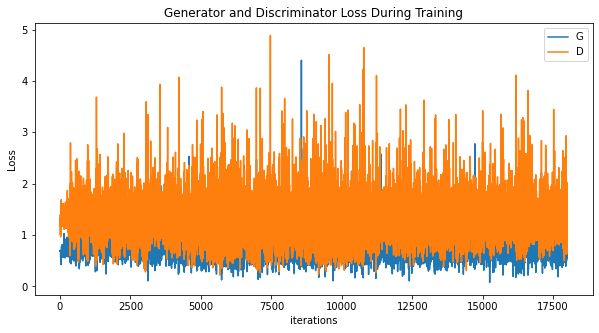

In [14]:
# plot loss

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

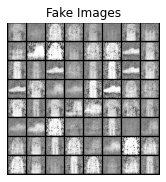

In [21]:
# plot images

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")

plt.imshow(np.transpose(img_list[-1].cpu(),(1,2,0)))

plt.show()

[4] Test

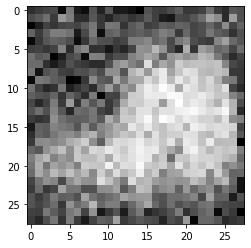

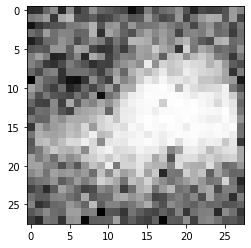

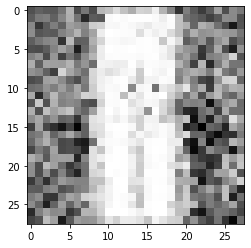

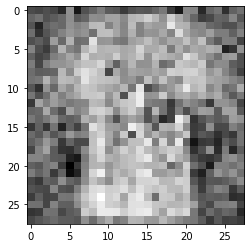

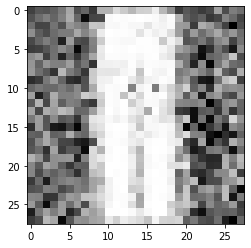

In [22]:
# generate any image

z_noise = torch.randn(5, z_size).to(device)
image = netG(z_noise).cpu()

for generated in (image):
    plt.imshow(generated.detach().numpy().reshape(28,28), cmap="gray")
    plt.show()